## Trabajo Semanal Extra - BETTIG
### Estimación espectral de PPG

<br> En el archivo <b>MAX30102_data_full.csv</b> tengo guardado la captura de una señal de PPG medida sobre mi dedo índice, la cual obtuve a través del sensor MAX30102 utilizado para mi proyecto final. El objetivo del trabajo aqui presente será indigar técnicas de filtrado que me permitan obtener la banda de frecuencia de interes. Para ello voy a levantar los datos del excel, hacer un análisis espectral, plantear filtros lineales y algún método alineal para comparar resultados.

### Desarrollo del Trabajo

#### Obtención de datos y estimación espectral

Primero que nada, voy a incluir las bibliotecas necesarias para el desarrollo de la tarea

In [1]:
import csv,os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig
from scipy import interpolate as interp

Seguido de ello, voy a obtener los datos del .csv antes mencionado:

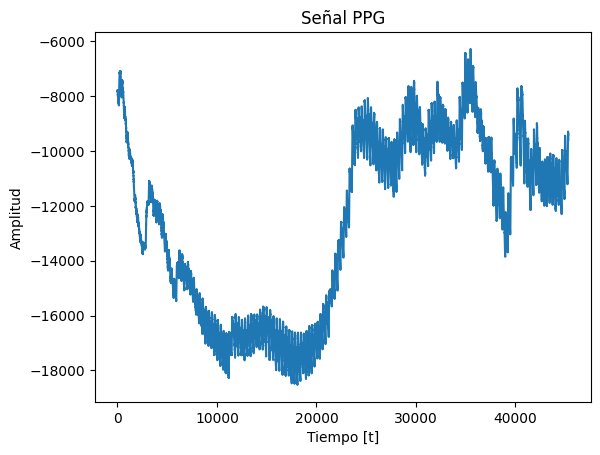

In [3]:
with open('MAX30102_data_full.csv', 'r') as csv_file:
    reader = csv.reader(csv_file);
    ppg_vec = np.array([]) 
    for row in reader:
        ppg_vec = np.append(ppg_vec, float(row[0]))
plt.figure(5)
plt.plot(ppg_vec)
plt.title('Señal PPG');
plt.xlabel('Tiempo [t]');  
plt.ylabel('Amplitud');

Para lograr visualizar un poco mejor cual es la forma de onda de cada uno de los pulsos, voy a hacer un zoom en una porción particular de la señal

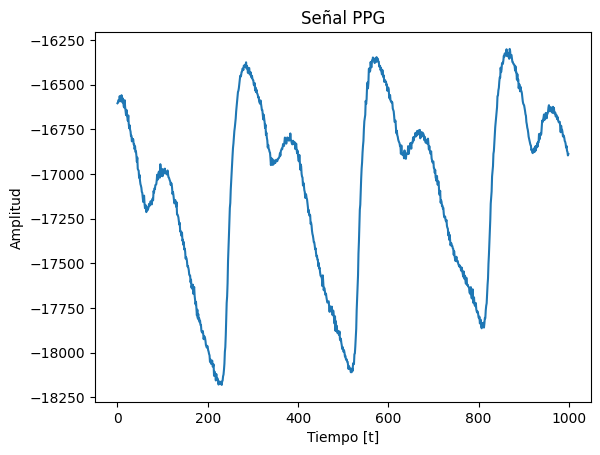

In [5]:
plt.figure(5)
plt.plot(ppg_vec[19000:20000]);
plt.title('Señal PPG');
plt.xlabel('Tiempo [t]');  
plt.ylabel('Amplitud');

A simple vista podemos observar que existe un ruido de alta frecuencia sobre la envolvente de la señal de interes y un ruido de muy baja frecuencia (movimiento de linea base) que afecta a la detección de cada uno de estos pulsos.

Voy a realizar la estimación espectral a través del método de Welch para conocer cuales seran las frecuencias de corte necesarias del filtro:

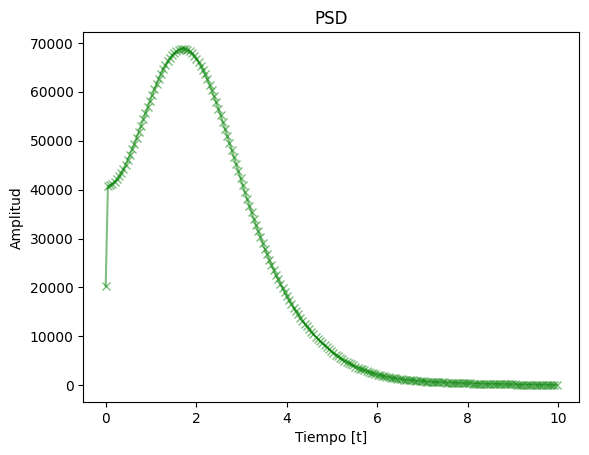

In [8]:
# Conozco la frecuencia de muestreo ya que el sensor lo configuré yo :)
fs = 400;
# Obtengo la PSD del vector a través de Welch
len_ppg    = len(ppg_vec);
welch_ppg  = np.empty((len_ppg, 1), float);
f_norm, welch_ppg = sig.welch(ppg_vec, fs, 'blackman', nfft = 8192, return_onesided=True)
f_filt = f_norm < 10;
plt.figure(6)
plt.plot(f_norm[f_filt], welch_ppg[f_filt], 'x-g', alpha=0.5)
plt.title('PSD');
plt.xlabel('Tiempo [t]');  
plt.ylabel('Amplitud');

Con un simple algoritmo voy a encontrar en que punto se concentra el 98% de la energía total de la señal:

In [9]:
# Ahora voy a buscar el ancho de banda útil de mi señal.
# Primero que nada, tengo que saber cual es la potencia total:
total_energy = np.sum(welch_ppg);
cumsum_energy = np.cumsum(welch_ppg);
# Voy a recorrer el vector cumsum hasta obtener un porcentaje de energía
bw_threshold = 0.98;
for i in range(len(cumsum_energy)):
    if (cumsum_energy[i] >= bw_threshold*total_energy):
        bw_ppg_i = i;
        break;
bw_ppg = f_norm[bw_ppg_i];
print("Energía útil -> BW: ", bw_ppg, "Hz");

Energía útil -> BW:  5.46875 Hz


Por ende, puedo establecer una frecuencia de corte superior en 7.5Hz para darle un cierto margen. Por otro lado, observando el gráfico de la PSD puedo establecer una frecuencia de corte inferior en 0.15Hz. Este valor salió de ver a partir de donde el gráfico comienza a tener valores significativos (mas un cierto margen)

Por ende, <b>la plantilla de mi filtro tendrá una frecuencia de corte inferior de 0,15 Hz y una frecuencia de corte superior de 7.5 Hz</b>

#### Filtrado

Como dije anteriormente, mi idea es aplicar distintos tipos de filtrado para poder comparar los mismos y evaluar si los mismos son útiles o no. Previo a esto, hay que tener en cuenta que lo que estoy buscando yo es la menor deformación posible en la morfología de la señal y a su vez que sea lo mas rápido posible (Y la implementación no sea un fastidio).
<br>Dicho esto, lo que voy a plantear es lo siguiente:
- Pasabanda Butterwoth IIR
- Pasabanda Butterworth FIR
- Filtrado alineal por estimación de linea base

El filtro pasabanda lo voy a hacer al concatenar un LPF y un HPF (ambos IIR), el código es el siguiente:

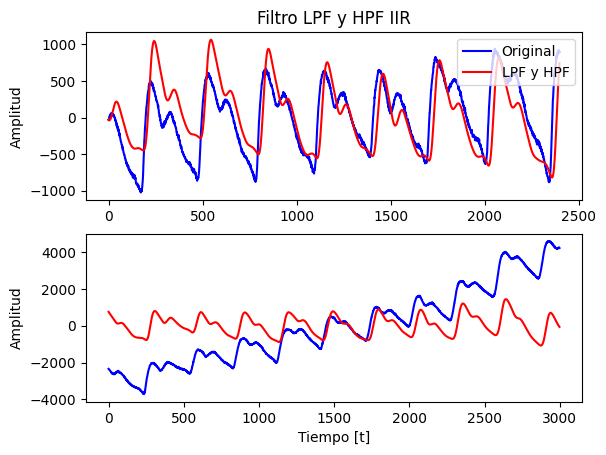

In [11]:
# Voy a empezar calculando el filtro pasa altos. Para ellos, establezco 
# que la frecuencia de corte sea de 0.15Hz y que sea de orden 4
f_cut = 0.15
N = 4
Wn = f_cut
sos_matrix_hpf = sig.butter(N, Wn, 'highpass', False, 'sos', fs)

# Voy a seguir filtro pasa bajos. Para ellos, establezco 
# que la frecuencia de corte sea de 7.5Hz y que sea de orden 4
f_cut = 7.5
N = 4
Wn = f_cut
sos_matrix_lpf = sig.butter(N, Wn, 'lowpass', False, 'sos', fs)

ppg_filt_1_lpf = sig.sosfilt(sos_matrix_lpf, ppg_vec);
ppg_filt_1     = sig.sosfilt(sos_matrix_hpf, ppg_filt_1_lpf);

ppg_t = np.arange(0, len(ppg_vec), 1);
time_filt_norm  = (ppg_t > 12600) & (ppg_t < 15000);
time_filt_lp    = (ppg_t > 21000) & (ppg_t < 24000);

fig6, (ax1, ax2) = plt.subplots(2);
ax1.set_title('Filtro LPF y HPF IIR');
ax1.plot(ppg_vec[time_filt_norm]-np.mean(ppg_vec[time_filt_norm]),      'b', label = 'Original');
ax1.plot(ppg_filt_1[time_filt_norm],        'r', label = 'LPF y HPF');
ax1.set(ylabel = 'Amplitud');
ax1.legend(loc = 'upper right');
ax2.plot(ppg_vec[time_filt_lp]-np.mean(ppg_vec[time_filt_lp]),      'b', label = 'Original');
ax2.plot(ppg_filt_1[time_filt_lp],        'r', label = 'LPF y HPF');
ax2.set(xlabel = 'Tiempo [t]', ylabel = 'Amplitud');

Si vemos el gráfico superior, vemos el primer problema: Debido al uso de filtros IIR tenemos una distorsión en la morfología de la señal. La misma puede observarse aroximadamente en la muestra 500. Si se presta atención a la señal roja, se ve como la misma es mucho mas "plana" que la azul en la zona donde debería estar el pie de onda.

Voy a seguir con el filtro FIR:

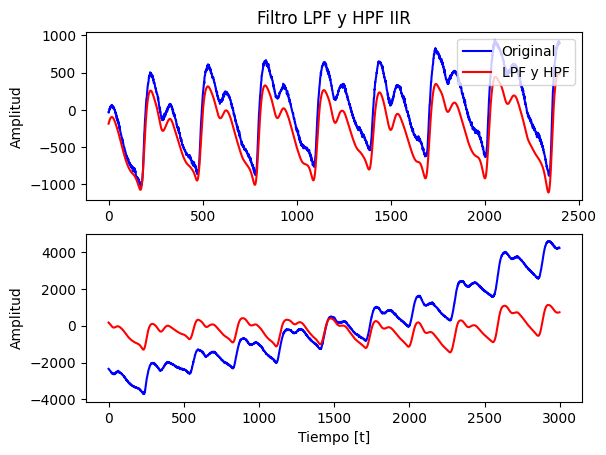

In [13]:
ws1         = 0.03 #Hz
wp1         = 0.15  #Hz
wp2         = 7.5 #Hz
ws2         = 20.0 #Hz
ripple      = 0.5 # dB
atenuacion  = 40  # dB

frecs    = np.array([0, ws1, wp1, wp2, ws2, (fs//2)])
gains    = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, 0])
gains    = 10**(gains/20)
gains[5] = 0

num_win    = sig.firwin2(10001, frecs, gains , window=('kaiser', 14), fs = fs)
ppg_filt_3 = sig.filtfilt(num_win, 1, ppg_vec, axis = 0)

fig6, (ax1, ax2) = plt.subplots(2);
ax1.set_title('Filtro LPF y HPF IIR');
ax1.plot(ppg_vec[time_filt_norm]-np.mean(ppg_vec[time_filt_norm]),      'b', label = 'Original');
ax1.plot(ppg_filt_3[time_filt_norm],        'r', label = 'FIR');
ax1.set(ylabel = 'Amplitud');
ax1.legend(loc = 'upper right');
ax2.plot(ppg_vec[time_filt_lp]-np.mean(ppg_vec[time_filt_lp]),      'b', label = 'Original');
ax2.plot(ppg_filt_3[time_filt_lp],        'r', label = 'FIR');
ax2.set(xlabel = 'Tiempo [t]', ylabel = 'Amplitud');

Por lo que se observa, el mismo funciona bastante bien, pero el principal problema de esto es que necesito demasiado coeficientes para que el resultado sea algo utilizable. Pero el filtrado se logra tanto en baja como en alta frecuencia y no existe distorsión de la morfología.

Por último, voy a plantear un filtrado alineal que se basa en la estimación de la linea base. Lo que voy a hacer es encontrar los puntos máximos y mínimos de la señal PPG, luego buscar un valor medio entre esos puntos y generar una señal interpolante. Por último, voy a sustraer esa señal interpolante de mi señal original y ver cual es el resultado:

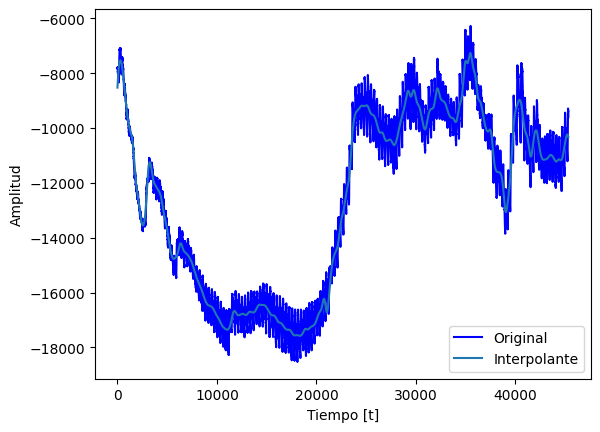

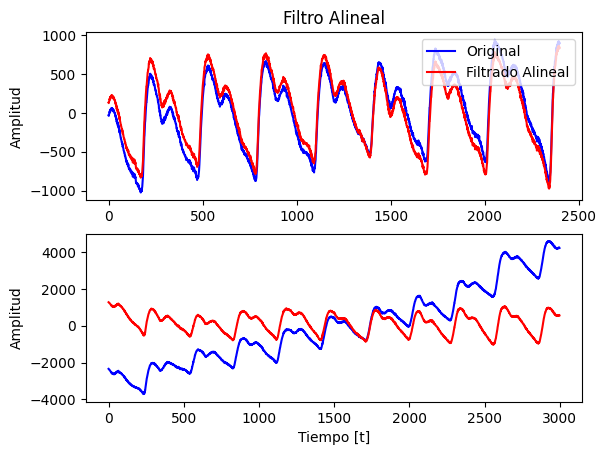

In [20]:
max_peaks = sig.find_peaks(ppg_vec, distance = 200)
min_peaks = sig.find_peaks(ppg_vec**2, distance = 200)
isoelectric_points = np.empty((1, len(max_peaks[0])), float);
isoelectric_grid = np.empty((1, len(max_peaks[0])), float);

for i in range(len(max_peaks[0])):
    max_value = max_peaks[0][i]
    min_value = min_peaks[0][i]
    isoelectric_points[0][i] = (ppg_vec[max_value] + ppg_vec[min_value])/2
    isoelectric_grid[0][i] = (max_value + min_value)/2

time_grid = np.arange(0, len(isoelectric_points[0]), 1);
ppg_grid= np.arange(0, len(ppg_vec), 1);

isoelectric_interp = interp.CubicSpline(isoelectric_grid[0], isoelectric_points[0]);
interp_ppg = ppg_vec-isoelectric_interp(ppg_grid);

plt.figure(5)
plt.plot(ppg_vec,      'b',    label = 'Original');
plt.plot(isoelectric_interp(ppg_grid), label = 'Interpolante');
plt.xlabel('Tiempo [t]');
plt.ylabel('Amplitud');
plt.legend();

fig6, (ax1, ax2) = plt.subplots(2);
ax1.set_title('Filtro Alineal');
ax1.plot(ppg_vec[time_filt_norm]-np.mean(ppg_vec[time_filt_norm]),      'b', label = 'Original');
ax1.plot(interp_ppg[time_filt_norm],        'r', label = 'Filtrado Alineal');
ax1.set(ylabel = 'Amplitud');
ax1.legend(loc = 'upper right');
ax2.plot(ppg_vec[time_filt_lp]-np.mean(ppg_vec[time_filt_lp]),      'b', label = 'Original');
ax2.plot(interp_ppg[time_filt_lp],        'r', label = 'Filtrado Alineal');
ax2.set(xlabel = 'Tiempo [t]', ylabel = 'Amplitud');

Primero que nada, este método solamente nos permite desprendernos del movimiento de la linea de base, luego habría que filtrarlo con un LPF para eliminar el ruido de alta frecuencia. De todas formas, a simple vista se observa que es el método que permite obtener de manera mas fidedigna la morfología de la señal. La gran desventaja es que el mismo no puede ser implementado en tiempo real